Las técnicas de *clustering*  es el proceso de separar diferentes partes de los datos basándose en características comunes. Distintos sectores, como el minorista, el financiero y el sanitario, utilizan este tipo de técnias para diversas tareas analíticas. 

- En el sector minorista, la agrupación puede ayudar a identificar distintas poblaciones de consumidores, lo que puede permitir a una empresa crear publicidad específica basada en datos demográficos de los consumidores que pueden ser demasiado complicados de inspeccionar manualmente. 

- En las finanzas, la agrupación puede detectar distintas formas de actividad ilegal en el mercado, como la falsificación de carteras de pedidos, en la que los operadores colocan con engaño grandes órdenes para presionar a otros operadores a comprar o vender un activo. 

- En el ámbito de la sanidad, los métodos de agrupación se han utilizado para averiguar los patrones de costes de los pacientes, los trastornos neurológicos de aparición temprana y la expresión genética del cáncer.

Además de seleccionar un algoritmo de clustering adecuado para el problema, también es necesario tener una forma de evaluar el rendimiento de estos algoritmos de clustering. Normalmente, para evaluar el rendimiento del modelo se utiliza la distancia media dentro del clúster desde el centro. En concreto, la distancia media de cada observación al centro del cluster, llamado centroide, se utiliza para medir la compacidad de un cluster. Esto tiene sentido porque un buen algoritmo de agrupación debe generar grupos de datos que estén muy juntos. Cuanto más cerca estén los puntos de datos dentro de un cluster, mejores serán los resultados del algoritmo. **La suma de la distancia dentro de un clúster representada contra el número de clústeres utilizados es una forma común de evaluar el rendimiento.**



In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
#import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
#import matplotlib.font_manager
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.preprocessing import StandardScaler


#from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Calidad de los clusters
# ==============================================================================
from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from scipy.spatial.distance import euclidean

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install yellowbrickç
#!pip install data-science-utils

In [3]:
df = pd.read_csv("data/Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


Vamos a eliminar la columna de `Gender` ya que no va a ser importante para este análisis

In [4]:
df.drop(["Gender"], axis = 1, inplace = True)

# Exploración y Preprocesamiento del dataset

## Duplicados

Chequeamos para ver si hay algún nulo en nuestro *dataframe*

In [5]:
df.duplicated().sum()

0

## Nulos
Chequeamos si hay algun nulo en el *dataframe*

In [6]:
df.isnull().sum()

Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

## *Outliers*

In [7]:
df_num = df.select_dtypes(include = np.number )

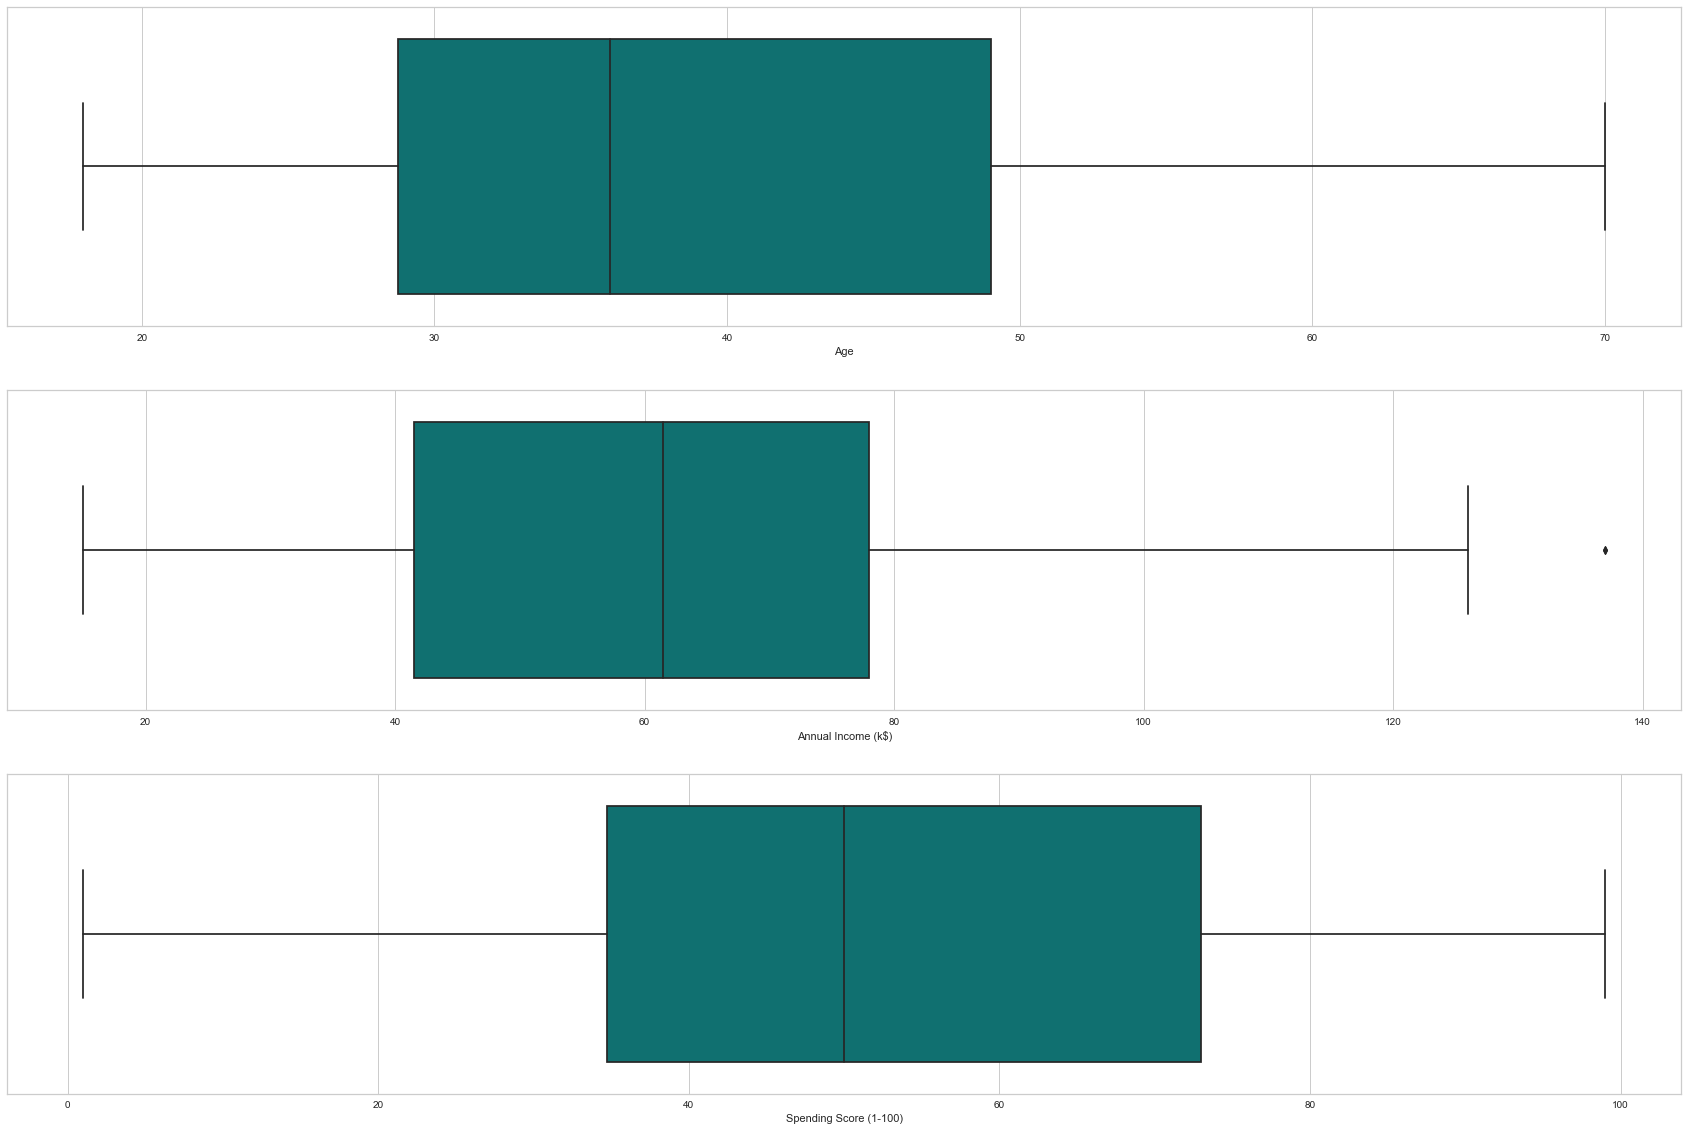

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(30,20))

for i in range(len(df_num.columns)):
    sns.boxplot(x=df_num.columns[i], data=df_num, ax=ax[i], color = "teal")
plt.show()

## Estandarización

In [242]:
sc = StandardScaler()
var_transformadas = sc.fit_transform(df)
var_transformadas[0]

array([-1.42456879, -1.73899919, -0.43480148])

In [243]:
df[df.columns] = var_transformadas

In [244]:
df.head()

,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,
1,-1.424569,-1.738999,-0.434801
2,-1.281035,-1.738999,1.195704
3,-1.352802,-1.700830,-1.715913
4,-1.137502,-1.700830,1.040418
5,-0.563369,-1.662660,-0.395980


# K-Means Clustering 

Lo primero que tenemos que hacer es determinar el número de *clusters* que utilizaremos. Podremos usar dos aproximaciones: 

- Usando la `inercia`:  mide lo bien que un conjunto de datos fue agrupado por K-Means. Se calcula midiendo la distancia entre cada punto de datos y su centroide, elevando al cuadrado esta distancia y sumando estos cuadrados en un clúster.

    Un buen modelo es el que tiene una baja inercia y un bajo número de clusters (K). Sin embargo, se trata de un compromiso, ya que a medida que K aumenta, la inercia disminuye.

    Para encontrar la K óptima para un conjunto de datos, utilizaremos el método del codo; el cual encuentra el punto en el que la disminución de la inercia comienza a disminuir.
    

- Usando el `silhouette`:  indica la distancia entre los puntos de datos de un grupo y los de otro grupo. El rango de la puntuación de la silueta es de -1 a 1. La puntuación debe estar más cerca de 1 que de -1.

    - Cuánto más cerca de 1 significa que el *cluster* está bien configurado, es decir, los datos dentro de un *cluster* son muy similares
    
    - Cuánto más cerca de -1 significa que el *cluster* está mal configurado, es decir, los datos dentro del *cluster* son muy diferentes, lo que hace que los puntos estén más separados y, por lo tanto, más cerca estarán los *clusters* 


## Selección número de clusters

### Usando `inercia`

In [264]:
inercia = []
clusters = range(1,11)
for i in clusters:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df)
    inercia.append(kmeans.inertia_)

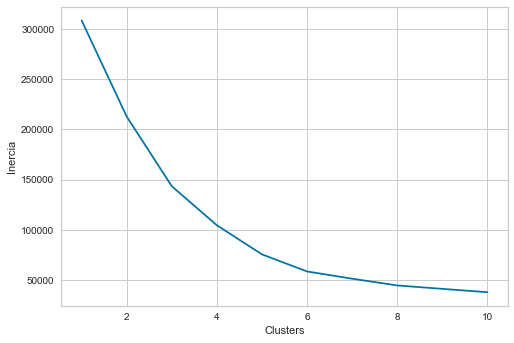

In [265]:
plt.plot(clusters, inercia)
plt.xlabel('Clusters')
plt.ylabel('Inercia')
plt.show()


### Usando silhouette score

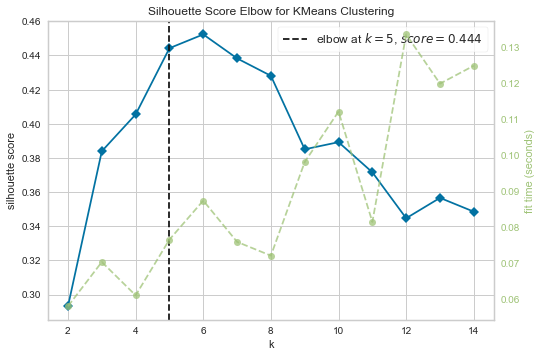

In [266]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette')
visualizer.fit(df)        
visualizer.show();

En cualquiera de los casos, parece que el mejor número de *clusters* es 5

## Ejecución del modelo

In [267]:
kmeans = KMeans(n_clusters=5)
km_fit = kmeans.fit(df)
y_kmeans = kmeans.predict(df)

Veamos algunas características del modelo: 

In [268]:
# los clusters que se han generado
labels = km_fit.labels_
labels

array([4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2,
       4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2,
       4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 0, 1, 0, 3, 0, 3, 0,
       3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 1, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0,
       3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0,
       3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0,
       3, 0])

In [269]:
# los centros de nuestros clusters

centroides = km_fit.cluster_centers_
centroides

array([[32.69230769, 86.53846154, 82.12820513],
       [43.08860759, 55.29113924, 49.56962025],
       [25.52173913, 26.30434783, 78.56521739],
       [40.66666667, 87.75      , 17.58333333],
       [45.2173913 , 26.30434783, 20.91304348]])

### Calidad del cluster

- `Cardinalidad`: número de puntos por cluster


- `Magnitud`: la suma de las distancias al centroide dentro de cada plot


- `Relación Cardinalidad-Magnitud`: una mayor cardinalidad de los clusters tiende a dar lugar a una mayor magnitud de los mismos, lo que intuitivamente tiene sentido. Los clusters son anómalos cuando la cardinalidad no se correlaciona con la magnitud en relación con los otros clusters.

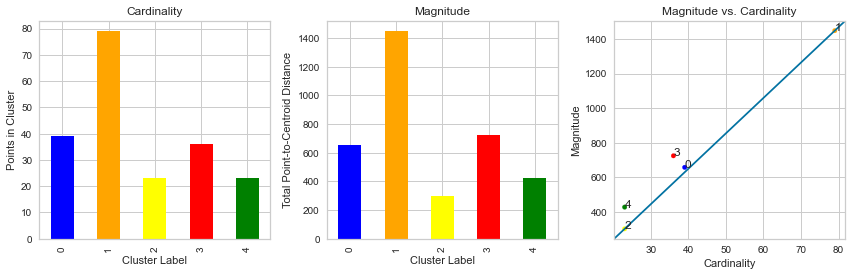

In [270]:
# definimos los colores de las gráficas
cluster_colors = ['blue', 'orange', 'yellow', 'red', 'green', 'purple']

# iniciamos los subplots
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

# ploteamos la CARDINALIDAD
plot_cluster_cardinality(labels, # las labels que predijo nuestro modelo
                         ax=ax1, # sobre que eje lo queremos hacer
                         title="Cardinality", # título de la gráfica
                         color=cluster_colors # colores que vamos a querer usar
                        )


# ploteamos la MAGNITUD
plot_cluster_magnitude(df, # el dataframe del que sacaremos los datos
                       labels, # las labels que predijo nuestro modelo
                       centroides, # los centroides de nuestros clusters
                       euclidean, # la distancia que quiero usar para medir
                       ax=ax2,
                       title="Magnitude",
                       color=cluster_colors
                      )

# ploteamos la RELACIÓN ENTRE CARDINALIDAD Y MAGNITUD
plot_magnitude_vs_cardinality(df,# el dataframe del que sacaremos los datos
                              labels, # las labels que predijo nuestro modelo
                              centroides, # los centroides de nuestros clusters
                              euclidean,# la distancia
                              color=cluster_colors[0:km_fit.n_clusters],
                              ax=ax3,
                              title="Magnitude vs. Cardinality")
plt.tight_layout()
plt.show()

### Entendiendo los clusters

In [271]:
df["Cluster"] = y_kmeans
df.head(2)

,Age,Annual Income (k$),Spending Score (1-100),Cluster
CustomerID,,,,
1,19,15,39,4
2,21,15,81,2


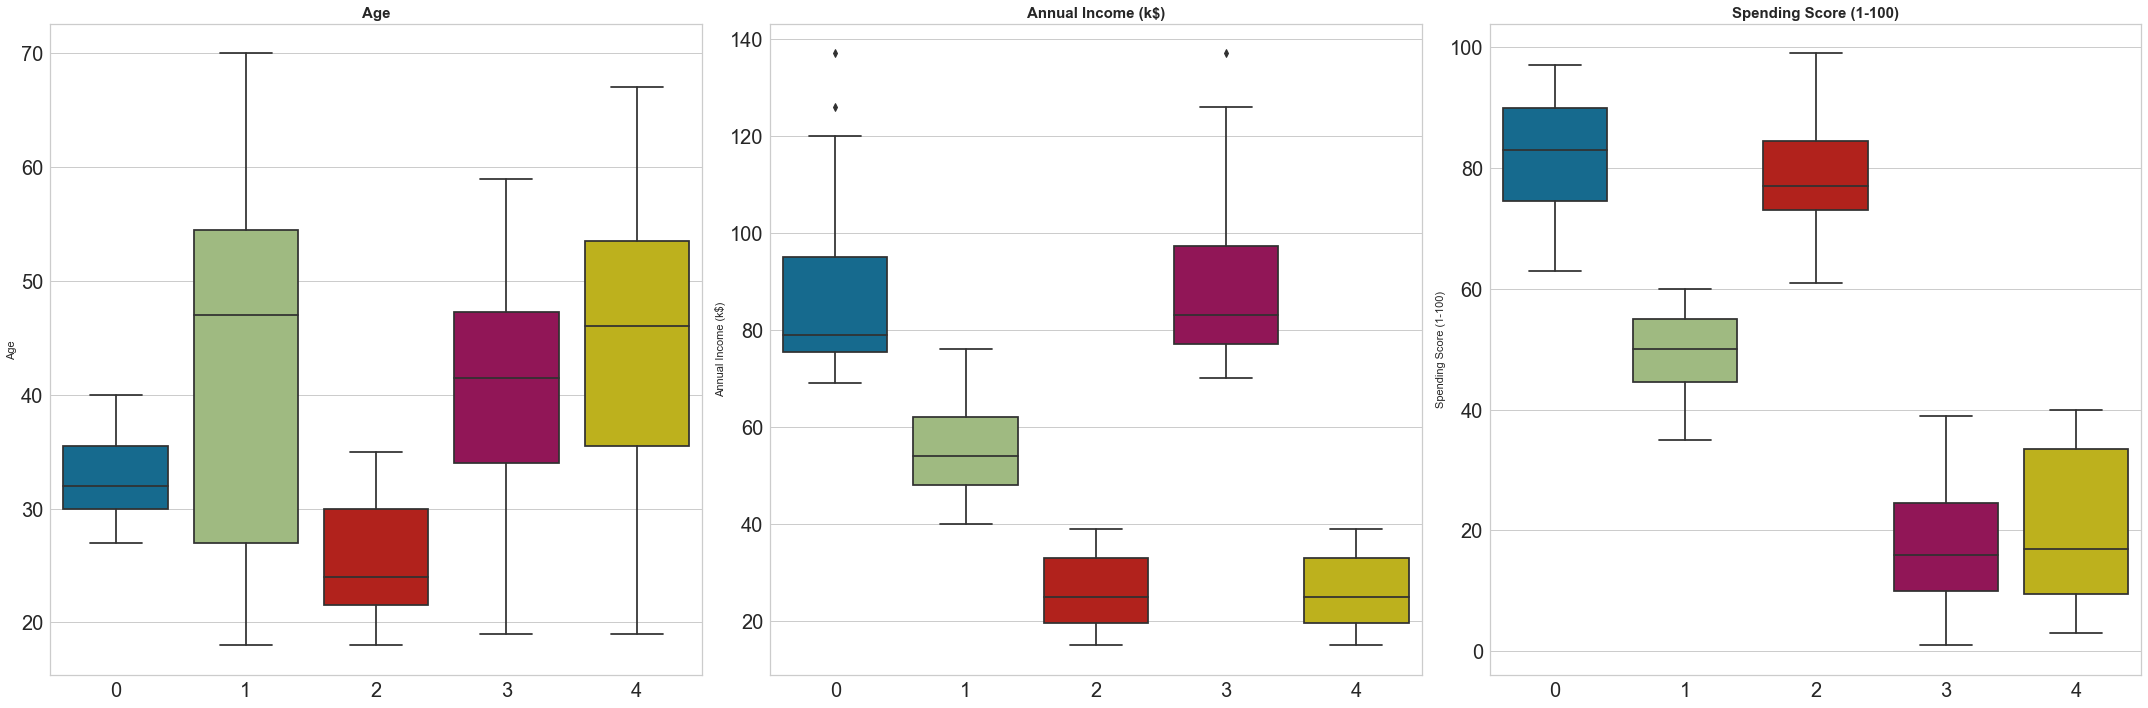

In [272]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))


axes = axes.flat

columnas = df.columns.drop("Cluster")

for i, colum in enumerate(columnas): 
    sns.boxplot(
        data = df,
        x = 'Cluster',
        y = colum, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")


fig.tight_layout();

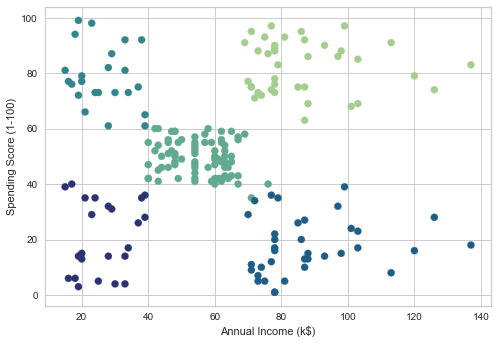

In [273]:
plt.scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"], c=df["Cluster"], s=50, cmap='crest')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show();

In [274]:
pca = PCA(2)
data_transformed = pd.DataFrame(pca.fit_transform(df), columns=["PC1","PC2"])
data_transformed.head()

,PC1,PC2
0,-31.519360,-33.394448
1,1.471422,-56.823846
2,-57.292206,-13.851673
3,-1.502213,-53.496661
4,-31.854060,-30.784908


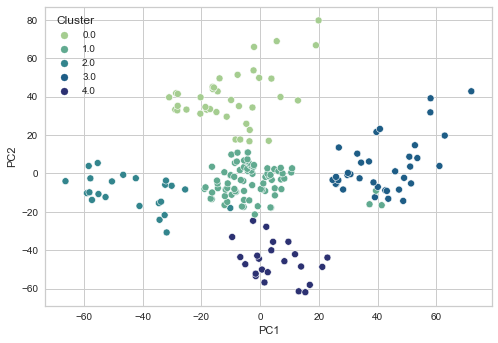

In [275]:
pca_plot = sns.scatterplot(data_transformed["PC1"],data_transformed["PC2"], hue= df["Cluster"], palette= "crest")
